## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Import modules, set options

In [149]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [150]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [151]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [152]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


#### Filter

In [153]:
#train_csv, _ = train_test_split(train_csv, test_size=0.9, random_state=42)

#### Train_CSV Params

In [154]:
train_csv.describe()

,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,6.915783e+04,1.335689e+01,5.883966e+00,1.589904e+01
std,3.661127e+04,3.267712e+00,4.993943e+00,3.477050e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01
25%,3.900200e+04,1.100000e+01,2.000000e+00,-2.549780e-01
50%,7.160900e+04,1.300000e+01,5.000000e+00,2.281130e+00
75%,1.008060e+05,1.600000e+01,8.000000e+00,7.390655e+00
max,1.338840e+05,2.800000e+01,2.800000e+01,2.048800e+02


In [155]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [156]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [157]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [158]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [159]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

### Functions

In [160]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [161]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [162]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [163]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [164]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))



def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [165]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [166]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [167]:
def build_couple_dataframeOld(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [168]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    output = output.drop(atoms_names, axis=1)
    return output

In [169]:
def map_atom_info(df, atom_idx):
    structures = structures_csv[['molecule_index', 'atom_index', 'atom']]
    structures = structures_csv
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_index', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_index',  'atom_index'])
    df = df.rename(columns={'atom': f'atom_{atom_idx}'});
    #df = df.drop('atom_index', axis=1)    
    return df

### Проверяем, что для каждого типа молекулы только  atom_1 принимает только одно значение

In [170]:
invest0 = map_atom_info(train_csv, 1)
invest0 = invest0[['type','atom_1']]
invest0.groupby(['type']).mean()

,atom_1
type,
1JHC,6
1JHN,7
2JHC,6
2JHH,1
2JHN,7
3JHC,6
3JHH,1
3JHN,7


## Check Regressions for a simple type

## New heading

In [171]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df


def build_atoms(base_from, structures_from, n_atoms):
    base = base_from
    structures = structures_from

    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in atoms:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)

    add_center(atoms)

    atoms = merge_all_atoms(atoms, structures)
        
    add_distance_to_center(atoms)

    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    atoms = atoms.drop(['atom_index'], axis=1)
    atoms = atoms.set_index(['x_c', 'y_c', 'z_c', 
        'molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()

    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    return atoms


In [172]:
def add_distance_to_center(df):
    df['d_c'] = ((
        ( df['x'] -  df['x_c'])**np.float32(2) +
        ( df['y'] -  df['y_c'])**np.float32(2) + 
        ( df['z'] -  df['z_c'])**np.float32(2)
    )**np.float32(0.5))
    

def cross_prod(v1, v2):
    outp0 = v1[1] * v2[2] - v1[2] * v2[1]
    outp1 = v1[2] * v2[0] - v1[0] * v2[2]
    outp2 = v1[0] * v2[1] - v1[1] * v2[0]
    outp = pd.concat([outp0, outp1,outp2], axis=1)
    return outp


def add_axis_x(df):
    n_x = df.x_0 - df.x_c
    n_y = df.y_0 - df.y_c
    n_z = df.z_0 - df.z_c
    axisFrame = pd.concat([n_x, n_y, n_z], axis=1)
    axisNorm = np.sqrt(np.square(axisFrame).sum(axis=1))
    df['ax_x'] = axisFrame[0] / axisNorm
    df['ax_y'] = axisFrame[1] / axisNorm
    df['ax_z'] = axisFrame[2] / axisNorm


def add_axis_y(df):
    r_vec = pd.concat([df.x_2 - df.x_c, 
                 df.y_2 - df.y_c,
                 df.z_2 - df.z_c], axis=1)
    axis_vec = pd.concat([df['ax_x'], 
                          df['ax_y'], 
                          df['ax_z']], axis=1)
    axis_vec.columns = [0, 1, 2]
    dist =  axis_vec[0] * r_vec[0] + axis_vec[1] * r_vec[1] + axis_vec[2] * r_vec[2]
    yDir = r_vec - axis_vec.multiply(dist, axis="index")
    yDirNorm = np.sqrt(np.square(yDir).sum(axis=1))
    df['ay_x'] = yDir[0] / yDirNorm
    df['ay_y'] = yDir[1] / yDirNorm
    df['ay_z'] = yDir[2] / yDirNorm    

def add_axis_z(df):    
    r_vec = pd.concat([df.x_2 - df.x_c, 
         df.y_2 - df.y_c,
         df.z_2 - df.z_c], axis=1)
    axis_x_vec = pd.concat([df['ax_x'], 
                      df['ax_y'], 
                      df['ax_z']], axis=1)
    axis_x_vec.columns = [0, 1, 2]
    axis_y_vec = pd.concat([df['ay_x'], 
                      df['ay_y'], 
                      df['ay_z']], axis=1)
    axis_y_vec.columns = [0, 1, 2]
    axis_z_vec = cross_prod(axis_x_vec, axis_y_vec)
    df['az_x'] = axis_z_vec[0] 
    df['az_y'] = axis_z_vec[1] 
    df['az_z'] = axis_z_vec[2] 


    
#add coordinates in frame ax,ay,az
def add_r_per_atom(df, suffix):
    x_loc = df[f'x_{suffix}'] - df.x_c
    y_loc = df[f'y_{suffix}'] - df.y_c
    z_loc = df[f'z_{suffix}'] - df.z_c
    r_x =  df['ax_x'] * x_loc + df['ax_y'] * y_loc + df['ax_z'] * z_loc
    r_y =  df['ay_x'] * x_loc + df['ay_y'] * y_loc + df['ay_z'] * z_loc
    r_z =  df['az_x'] * x_loc + df['az_y'] * y_loc + df['az_z'] * z_loc
    df[f'r_x_{suffix}'] = r_x
    df[f'r_y_{suffix}'] = r_y
    df[f'r_z_{suffix}'] = r_z
            
def add_r(df):    
    n_atoms = len([col for col in df if col.startswith('x_')]) - 1
    for i in range(1, n_atoms):
            add_r_per_atom(df, i)
            
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    
    atoms = build_atoms(base, structures, n_atoms)
    df = add_atoms(base, atoms)
    
    add_axis_x(df)
    add_axis_y(df)
    add_axis_z(df)
    add_r(df)

    df.sort_values('id', inplace=True)
    return df


In [173]:
%%time
molecule_index = 50893
some_csv = train_csv[train_csv.molecule_index == molecule_index]
#some_csv = train_csv #[:6000]
coupling_type = '1JHC'
n_atoms = 10
full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms)
full.head()

Wall time: 127 ms


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,ax_x,ax_y,ax_z,ay_x,ay_y,ay_z,az_x,az_y,az_z,r_x_1,r_y_1,r_z_1,r_x_2,r_y_2,r_z_2,r_x_3,r_y_3,r_z_3,r_x_4,r_y_4,r_z_4,r_x_5,r_y_5,r_z_5,r_x_6,r_y_6,r_z_6,r_x_7,r_y_7,r_z_7,r_x_8,r_y_8,r_z_8,r_x_9,r_y_9,r_z_9
0,1567330,50893,10,1,140.645004,0.634779,-0.462826,-0.739286,-0.133810,0.038041,-0.150691,0.250485,-0.212392,-0.444989,7,8,1,6,8,7,1,1,-0.256479,-1.090539,0.509465,-0.941471,-0.039216,-1.970939,-2.699512,-1.220216,1.252988,-0.831051,1.787187,-2.158229,-2.629475,-2.850358,-2.328591,-4.609975,0.143031,0.318055,-0.264027,0.003972,-0.643397,0.563172,1.023855,-0.179480,0.705145,-0.459522,-0.540008,0.459768,0.876096,-0.145150,0.539799,-0.145927,0.829049,-0.544986,8.690331e-09,-1.344103e-08,-1.348394,0.965377,1.665335e-16,-1.073379,-1.269321,-0.001004,-0.833953,1.844628,-0.001969,-0.188789,-2.317930,0.012743,1.013565,-2.221993,0.031846,-0.898638,-3.478787,0.021642,-1.900923,-3.423511,-0.065852,0.840353,-4.567426,0.067962
1,1567340,50893,12,6,103.942001,-1.220216,-4.609975,-0.179480,-2.127082,-4.268234,0.327516,-1.673649,-4.439105,0.074018,1,7,6,6,1,8,7,8,-2.210247,-1.970939,-3.300507,-0.941471,-2.699512,-0.039216,-4.236725,-1.090539,-4.815596,-2.850358,-4.583531,-2.158229,-2.328591,-2.629475,-4.827504,-0.831051,1.273320,0.563172,-0.501114,0.003972,1.023855,-0.643397,-1.131620,0.318055,0.829152,-0.312455,-0.463550,0.187651,-0.625536,0.757293,-0.526587,-0.714896,-0.460032,-0.546864,-3.206483e-07,-2.781151e-07,-0.883221,1.043038,-1.110223e-16,-0.969658,-0.679172,-1.204267,-1.037184,-0.650480,1.224511,-0.073115,-1.342422,-1.983922,-1.950334,-0.793401,-1.405548,1.122323,-1.368580,-1.824335,-1.444950,-1.151026,2.181979,-0.756991,-1.962738,-2.998708
2,1567346,50893,13,6,92.774101,-2.210247,-4.815596,1.273320,-2.127082,-4.268234,0.327516,-2.168664,-4.541915,0.800418,1,7,6,1,6,7,8,8,-1.220216,-1.970939,-3.300507,-2.699512,-0.941471,-4.236725,-0.039216,-1.090539,-4.609975,-2.850358,-4.583531,-2.328591,-2.158229,-4.827504,-2.629475,-0.831051,-0.179480,0.563172,-0.501114,1.023855,0.003972,-1.131620,-0.643397,0.318055,-0.075885,-0.499449,0.863014,0.846727,-0.489362,-0.208753,0.526587,0.714896,0.460032,-0.547966,-2.080969e-07,-1.118382e-07,-0.883646,1.040940,-1.110223e-16,-1.064597,-0.610838,1.204266,-1.016565,-0.666298,-1.224512,-0.872329,-1.579242,1.405547,-1.970999,0.038874,1.983921,-1.367803,-1.208008,-2.181981,-2.362792,1.168588,1.824335,-2.351486,-0.802381,2.998706


## Break!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [174]:
#aaaa

## New heading

In [196]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHC', n_atoms=10)
full.head()

Wall time: 30.2 s


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,ax_x,ax_y,ax_z,ay_x,ay_y,ay_z,az_x,az_y,az_z,r_x_1,r_y_1,r_z_1,r_x_2,r_y_2,r_z_2,r_x_3,r_y_3,r_z_3,r_x_4,r_y_4,r_z_4,r_x_5,r_y_5,r_z_5,r_x_6,r_y_6,r_z_6,r_x_7,r_y_7,r_z_7,r_x_8,r_y_8,r_z_8,r_x_9,r_y_9,r_z_9
0,0,1,1,0,84.807602,0.002150,-0.006031,0.001976,-0.012698,1.085804,0.008001,-0.005274,0.539886,0.004989,1,1,1,0,0,0,0,0,1.011731,-0.540815,-0.523814,NaN,NaN,NaN,NaN,NaN,1.463751,1.447527,1.437933,NaN,NaN,NaN,NaN,NaN,0.000277,-0.876644,0.906397,NaN,NaN,NaN,NaN,NaN,0.013598,-0.999892,-0.005518,0.999862,0.013650,-0.009453,0.009528,-0.005388,0.999940,-0.545976,-1.050371e-09,2.263989e-10,-0.909910,1.029520e+00,3.469447e-18,-0.909960,-0.514744,-0.891572,-0.909974,-0.514731,0.891575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,1,2,0,84.807404,1.011731,1.463751,0.000277,-0.012698,1.085804,0.008001,0.499516,1.274778,0.004139,1,1,1,0,0,0,0,0,0.002150,-0.523814,-0.540815,NaN,NaN,NaN,NaN,NaN,-0.006031,1.437933,1.447527,NaN,NaN,NaN,NaN,NaN,0.001976,0.906397,-0.876644,NaN,NaN,NaN,NaN,NaN,0.938163,0.346121,-0.007074,0.346062,-0.938175,-0.008353,-0.009528,0.005388,-0.999940,-0.545976,-7.734600e-09,2.711641e-10,-0.909910,1.029521e+00,-4.336809e-19,-0.909962,-0.514740,-0.891575,-0.909978,-0.514731,0.891572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,1,3,0,84.809303,-0.540815,1.447527,-0.876644,-0.012698,1.085804,0.008001,-0.276757,1.266665,-0.434321,1,1,1,0,0,0,0,0,-0.523814,0.002150,1.011731,NaN,NaN,NaN,NaN,NaN,1.437933,-0.006031,1.463751,NaN,NaN,NaN,NaN,NaN,0.906397,0.001976,0.000277,NaN,NaN,NaN,NaN,NaN,-0.483647,0.331264,-0.810154,-0.667473,0.459163,0.586216,0.566185,0.824277,-0.000963,-0.545973,3.020596e-08,-1.268035e-08,-0.909965,1.029495e+00,1.084202e-17,-0.909959,-0.514773,-0.891563,-0.909977,-0.514767,0.891557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,1,4,0,84.809502,-0.523814,1.437933,0.906397,-0.012698,1.085804,0.008001,-0.268256,1.261868,0.457199,1,1,1,0,0,0,0,0,-0.540815,1.011731,0.002150,NaN,NaN,NaN,NaN,NaN,1.447527,1.463751,-0.006031,NaN,NaN,NaN,NaN,NaN,-0.876644,0.000277,0.001976,NaN,NaN,NaN,NaN,NaN,-0.468077,0.322477,0.822747,-0.678482,0.465376,-0.568407,-0.566185,-0.824277,0.000963,-0.545974,3.428866e-10,1.268035e-08,-0.909966,1.029493e+00,-2.992398e-17,-0.909961,-0.514779,-0.891557,-0.909973,-0.514764,0.891563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17,5,2,0,171.220001,-0.027803,2.198949,0.014154,-0.013324,1.132466,0.008276,-0.020563,1.665708,0.011215,7,0,0,0,0,0,0,0,0.002311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.019159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.013575,0.999893,0.005511,0.524973,0.002436,0.851115,0.851010,0.014447,-0.524950,-0.533299,4.108457e-08,-1.370526e-10,-1.685047,1.296874e-07,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(1, n_atoms):
        labels.append(f'r_x_{i}')
    for i in range(2, n_atoms):
        labels.append(f'r_y_{i}')
    for i in range(3, n_atoms):
        labels.append(f'r_z_{i}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    #atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    #output = output.drop(atoms_names, axis=1)
    return output

In [198]:
df = take_n_atoms(full, 10)
df.head()


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,r_x_1,r_x_2,r_x_3,r_x_4,r_x_5,r_x_6,r_x_7,r_x_8,r_x_9,r_y_2,r_y_3,r_y_4,r_y_5,r_y_6,r_y_7,r_y_8,r_y_9,r_z_3,r_z_4,r_z_5,r_z_6,r_z_7,r_z_8,r_z_9,scalar_coupling_constant
0,1,1,1,0,0,0,0,0,-0.545976,-0.909910,-0.909960,-0.909974,NaN,NaN,NaN,NaN,NaN,1.029520e+00,-0.514744,-0.514731,NaN,NaN,NaN,NaN,NaN,-0.891572,0.891575,NaN,NaN,NaN,NaN,NaN,84.807602
1,1,1,1,0,0,0,0,0,-0.545976,-0.909910,-0.909962,-0.909978,NaN,NaN,NaN,NaN,NaN,1.029521e+00,-0.514740,-0.514731,NaN,NaN,NaN,NaN,NaN,-0.891575,0.891572,NaN,NaN,NaN,NaN,NaN,84.807404
2,1,1,1,0,0,0,0,0,-0.545973,-0.909965,-0.909959,-0.909977,NaN,NaN,NaN,NaN,NaN,1.029495e+00,-0.514773,-0.514767,NaN,NaN,NaN,NaN,NaN,-0.891563,0.891557,NaN,NaN,NaN,NaN,NaN,84.809303
3,1,1,1,0,0,0,0,0,-0.545974,-0.909966,-0.909961,-0.909973,NaN,NaN,NaN,NaN,NaN,1.029493e+00,-0.514779,-0.514764,NaN,NaN,NaN,NaN,NaN,-0.891557,0.891563,NaN,NaN,NaN,NaN,NaN,84.809502
4,7,0,0,0,0,0,0,0,-0.533299,-1.685047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.296874e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.220001


For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [200]:
#df = take_n_atoms(full, 9)

#inverse of distances
#filter_col = [col for col in df if col.startswith('d_')]
#df[filter_col] = 1 / (df[filter_col])
#df.head()

# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'r_x_1', 'r_x_2', 'r_x_3', 'r_x_4', 'r_x_5', 'r_x_6', 'r_x_7',
       'r_x_8', 'r_x_9', 'r_y_2', 'r_y_3', 'r_y_4', 'r_y_5', 'r_y_6', 'r_y_7',
       'r_y_8', 'r_y_9', 'r_z_3', 'r_z_4', 'r_z_5', 'r_z_6', 'r_z_7', 'r_z_8',
       'r_z_9', 'scalar_coupling_constant'],
      dtype='object')

In [179]:
# df.hist(bins=10, figsize = [20,20] )

In [180]:
#df.plot.scatter(x='dist_along_1', y = 'scalar_coupling_constant') 

In [199]:
#X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
#y_data = df['scalar_coupling_constant'].values.astype('float32')
X_data = df.drop(['scalar_coupling_constant'], axis=1)
y_data = df['scalar_coupling_constant']


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((567532, 32), (141884, 32), (567532,), (141884,))

## CatBoost

In [182]:
from catboost import CatBoostRegressor

In [183]:
CAT_PARAMS = {
          'learning_rate': 0.5,
           'max_depth': 5,    
           'n_estimators': 50
         }
#categorical features

categorical_features = [col for col in X_train if col.startswith('atom_')]
model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
          cat_features = categorical_features,
          use_best_model=True,
          verbose=True)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

0:	learn: 98.2955513	test: 140.5825043	best: 140.5825043 (0)	total: 3.04ms	remaining: 149ms
1:	learn: 98.2330513	test: 140.5200043	best: 140.5200043 (1)	total: 5.91ms	remaining: 142ms
2:	learn: 98.1705513	test: 140.4575043	best: 140.4575043 (2)	total: 8.36ms	remaining: 131ms
3:	learn: 98.1080513	test: 140.3950043	best: 140.3950043 (3)	total: 11ms	remaining: 126ms
4:	learn: 98.0455513	test: 140.3325043	best: 140.3325043 (4)	total: 13.7ms	remaining: 123ms
5:	learn: 97.9830513	test: 140.2700043	best: 140.2700043 (5)	total: 16.1ms	remaining: 118ms
6:	learn: 97.9205513	test: 140.2075043	best: 140.2075043 (6)	total: 18.7ms	remaining: 115ms
7:	learn: 97.8580513	test: 140.1450043	best: 140.1450043 (7)	total: 21.1ms	remaining: 111ms
8:	learn: 97.7955513	test: 140.0825043	best: 140.0825043 (8)	total: 23.6ms	remaining: 107ms
9:	learn: 97.7330513	test: 140.0200043	best: 140.0200043 (9)	total: 26.4ms	remaining: 106ms
10:	learn: 97.6705513	test: 139.9575043	best: 139.9575043 (10)	total: 28.9ms	remai

4.923769392142518

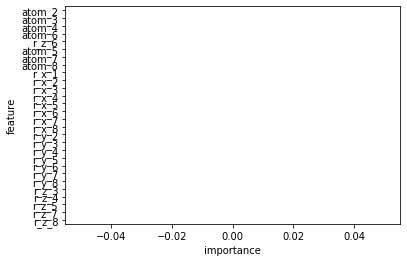

In [184]:
cols = list(X_train.columns)
#cols.remove('scalar_coupling_constant')
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

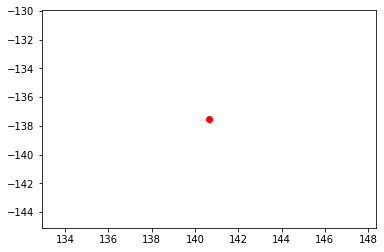

In [185]:
plt.plot(y_val, y_pred - y_val, 'ro')

## LGBMRegressor

In [186]:
#aaa

In [221]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
if False:
    LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
    }
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 64,
    'min_child_samples': 60,
    'max_depth': 6,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [222]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=10000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=500)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 500 rounds.
[100]	training's l1: 1.55161	valid_1's l1: 1.58178
[200]	training's l1: 1.36037	valid_1's l1: 1.40363
[300]	training's l1: 1.25043	valid_1's l1: 1.30687
[400]	training's l1: 1.17537	valid_1's l1: 1.24248
[500]	training's l1: 1.11944	valid_1's l1: 1.19707
[600]	training's l1: 1.07301	valid_1's l1: 1.16039
[700]	training's l1: 1.0329	valid_1's l1: 1.12977
[800]	training's l1: 1.00001	valid_1's l1: 1.10551
[900]	training's l1: 0.970685	valid_1's l1: 1.08476
[1000]	training's l1: 0.945939	valid_1's l1: 1.06762
[1100]	training's l1: 0.923102	valid_1's l1: 1.05244
[1200]	training's l1: 0.901672	valid_1's l1: 1.03821
[1300]	training's l1: 0.881791	valid_1's l1: 1.02571
[1400]	training's l1: 0.863749	valid_1's l1: 1.01424
[1500]	training's l1: 0.846797	valid_1's l1: 1.00393
[1600]	training's l1: 0.831073	valid_1's l1: 0.994356
[1700]	training's l1: 0.816278	valid_1's l1: 0.985238
[1800]	training's l1: 0.802415	valid_1's l1: 0.97705

-0.21619738888727927

Not a bad score for such a simple set of features.

In [228]:
tmp = y_pred- y_val
tmp.describe()

count    141884.000000
mean     0.005461     
std      1.217053     
min     -45.175956    
25%     -0.511672     
50%      0.015885     
75%      0.528240     
max      23.178317    
Name: scalar_coupling_constant, dtype: float64

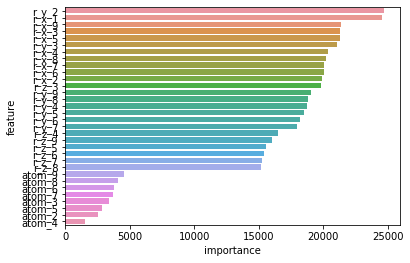

In [219]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

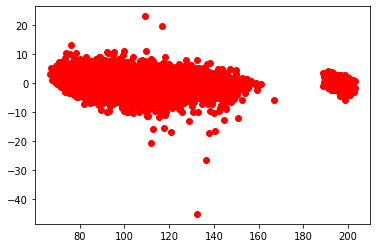

In [223]:
plt.plot(y_val, y_pred- y_val, 'ro')

In [230]:
np.power(2,6)

64

It's funny, but looks like atom types aren't used a lot in the final decision. Quite a contrary to what a man would do.

## Submission Model


In [231]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1)
        y_data = df['scalar_coupling_constant']
    else:
        X_data = df
        y_data = None
    
    return X_data, y_data

In [232]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    model_type =  'lgb' #lgb  cat
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    columns = X_data.columns 
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        #X_train, X_val = X_data[train_index], X_data[val_index]
        #y_train, y_val = y_data[train_index], y_data[val_index]
        X_train, X_val = X_data[columns].iloc[train_index], X_data[columns].iloc[val_index]
        y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

        model = ""
        if model_type == 'lgb':
            model = LGBMRegressor(**LGB_PARAMS, n_estimators=10000, n_jobs = -1)
            #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
            model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
                verbose=100, early_stopping_rounds=200)
        
        if model_type == 'cat': 
            categorical_features = [col for col in X_train if col.startswith('atom_')]
            model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
            X_trainGlob = X_train
            model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
                      cat_features = categorical_features,
                      use_best_model=True,
                      verbose=False)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [233]:
categorical_features

['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8']

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [234]:
if False: 
    model_params = {
        '1JHC': 10,
        '1JHN': 7,    
        '2JHH': 9,
        '2JHN': 9,
        '2JHC': 9,
        '3JHH': 9,
        '3JHC': 10,
        '3JHN': 10
    }
model_params = {
        '1JHC': 10,
        '1JHN': 7,    
        '2JHH': 9,
        '2JHN': 9,
        '2JHC': 9,
        '3JHH': 9,
        '3JHC': 10,
        '3JHN': 10
    }


Checking cross-validation scores for each type:

In [235]:
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHC ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'r_x_1', 'r_x_2', 'r_x_3', 'r_x_4', 'r_x_5', 'r_x_6', 'r_x_7',
       'r_x_8', 'r_x_9', 'r_y_2', 'r_y_3', 'r_y_4', 'r_y_5', 'r_y_6', 'r_y_7',
       'r_y_8', 'r_y_9', 'r_z_3', 'r_z_4', 'r_z_5', 'r_z_6', 'r_z_7', 'r_z_8',
       'r_z_9', 'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'r_x_1', 'r_x_2', 'r_x_3', 'r_x_4', 'r_x_5', 'r_x_6', 'r_x_7',
       'r_x_8', 'r_x_9', 'r_y_2', 'r_y_3', 'r_y_4', 'r_y_5', 'r_y_6', 'r_y_7',
       'r_y_8', 'r_y_9', 'r_z_3', 'r_z_4', 'r_z_5', 'r_z_6', 'r_z_7', 'r_z_8',
       'r_z_9'],
      dtype='object')
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 1.55222	valid_1's l1: 1.58407
[200]	training's l1: 1.36133	valid_1's l1: 1.40663
[300]	training's l1: 1.254	valid_1's l1: 1.3116
[400]	training's l1

[3600]	training's l1: 0.631981	valid_1's l1: 0.884295
[3700]	training's l1: 0.625224	valid_1's l1: 0.881349
[3800]	training's l1: 0.618516	valid_1's l1: 0.87827
[3900]	training's l1: 0.612379	valid_1's l1: 0.875794
[4000]	training's l1: 0.605921	valid_1's l1: 0.873401
[4100]	training's l1: 0.59991	valid_1's l1: 0.870891
[4200]	training's l1: 0.593794	valid_1's l1: 0.868508
[4300]	training's l1: 0.587888	valid_1's l1: 0.866083
[4400]	training's l1: 0.582058	valid_1's l1: 0.863794
[4500]	training's l1: 0.576815	valid_1's l1: 0.861778
[4600]	training's l1: 0.571276	valid_1's l1: 0.85968
[4700]	training's l1: 0.565848	valid_1's l1: 0.857582
[4800]	training's l1: 0.560746	valid_1's l1: 0.855437
[4900]	training's l1: 0.555819	valid_1's l1: 0.853401
[5000]	training's l1: 0.550853	valid_1's l1: 0.851599
[5100]	training's l1: 0.546127	valid_1's l1: 0.849888
[5200]	training's l1: 0.541229	valid_1's l1: 0.848161
[5300]	training's l1: 0.536477	valid_1's l1: 0.84634
[5400]	training's l1: 0.531704	v

[8600]	training's l1: 0.422384	valid_1's l1: 0.810333
[8700]	training's l1: 0.419586	valid_1's l1: 0.809607
[8800]	training's l1: 0.416853	valid_1's l1: 0.80876
[8900]	training's l1: 0.414215	valid_1's l1: 0.808151
[9000]	training's l1: 0.411525	valid_1's l1: 0.807454
[9100]	training's l1: 0.408947	valid_1's l1: 0.806854
[9200]	training's l1: 0.406365	valid_1's l1: 0.806133
[9300]	training's l1: 0.40373	valid_1's l1: 0.80533
[9400]	training's l1: 0.40117	valid_1's l1: 0.804723
[9500]	training's l1: 0.398687	valid_1's l1: 0.804057
[9600]	training's l1: 0.39614	valid_1's l1: 0.803376
[9700]	training's l1: 0.393622	valid_1's l1: 0.802753
[9800]	training's l1: 0.391083	valid_1's l1: 0.802128
[9900]	training's l1: 0.388576	valid_1's l1: 0.801427
[10000]	training's l1: 0.386215	valid_1's l1: 0.80091
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.386215	valid_1's l1: 0.80091
1JHC Fold 2, logMAE: -0.22200663940382329
*** Training Model for 1JHN ***
Index(['atom_2', 'a

[3000]	training's l1: 0.139825	valid_1's l1: 0.454343
[3100]	training's l1: 0.135829	valid_1's l1: 0.453788
[3200]	training's l1: 0.132082	valid_1's l1: 0.453497
[3300]	training's l1: 0.128505	valid_1's l1: 0.452952
[3400]	training's l1: 0.125117	valid_1's l1: 0.452408
[3500]	training's l1: 0.121862	valid_1's l1: 0.451944
[3600]	training's l1: 0.118805	valid_1's l1: 0.451818
[3700]	training's l1: 0.115768	valid_1's l1: 0.451795
[3800]	training's l1: 0.112814	valid_1's l1: 0.451237
[3900]	training's l1: 0.110139	valid_1's l1: 0.450831
[4000]	training's l1: 0.107529	valid_1's l1: 0.450542
[4100]	training's l1: 0.105004	valid_1's l1: 0.450083
[4200]	training's l1: 0.102632	valid_1's l1: 0.45002
[4300]	training's l1: 0.100018	valid_1's l1: 0.44984
[4400]	training's l1: 0.0976369	valid_1's l1: 0.449336
[4500]	training's l1: 0.0953979	valid_1's l1: 0.449193
[4600]	training's l1: 0.0931709	valid_1's l1: 0.449081
[4700]	training's l1: 0.091012	valid_1's l1: 0.448759
[4800]	training's l1: 0.088

[400]	training's l1: 0.24812	valid_1's l1: 0.277787
[500]	training's l1: 0.233576	valid_1's l1: 0.26678
[600]	training's l1: 0.222078	valid_1's l1: 0.258518
[700]	training's l1: 0.212505	valid_1's l1: 0.251773
[800]	training's l1: 0.203715	valid_1's l1: 0.245815
[900]	training's l1: 0.196565	valid_1's l1: 0.241194
[1000]	training's l1: 0.189783	valid_1's l1: 0.237016
[1100]	training's l1: 0.183706	valid_1's l1: 0.233225
[1200]	training's l1: 0.178602	valid_1's l1: 0.23022
[1300]	training's l1: 0.173652	valid_1's l1: 0.22741
[1400]	training's l1: 0.169171	valid_1's l1: 0.224922
[1500]	training's l1: 0.164917	valid_1's l1: 0.222656
[1600]	training's l1: 0.160621	valid_1's l1: 0.220356
[1700]	training's l1: 0.156732	valid_1's l1: 0.218307
[1800]	training's l1: 0.15319	valid_1's l1: 0.21642
[1900]	training's l1: 0.149892	valid_1's l1: 0.214832
[2000]	training's l1: 0.146712	valid_1's l1: 0.213202
[2100]	training's l1: 0.143726	valid_1's l1: 0.211755
[2200]	training's l1: 0.140856	valid_1's

[5200]	training's l1: 0.0907414	valid_1's l1: 0.189632
[5300]	training's l1: 0.0896349	valid_1's l1: 0.189303
[5400]	training's l1: 0.0885715	valid_1's l1: 0.188948
[5500]	training's l1: 0.087547	valid_1's l1: 0.188582
[5600]	training's l1: 0.0864641	valid_1's l1: 0.18831
[5700]	training's l1: 0.0854678	valid_1's l1: 0.188033
[5800]	training's l1: 0.0844669	valid_1's l1: 0.18774
[5900]	training's l1: 0.0834996	valid_1's l1: 0.187426
[6000]	training's l1: 0.0825376	valid_1's l1: 0.187178
[6100]	training's l1: 0.0815874	valid_1's l1: 0.186939
[6200]	training's l1: 0.080617	valid_1's l1: 0.186675
[6300]	training's l1: 0.07969	valid_1's l1: 0.186391
[6400]	training's l1: 0.0787596	valid_1's l1: 0.18611
[6500]	training's l1: 0.0779306	valid_1's l1: 0.185847
[6600]	training's l1: 0.0770583	valid_1's l1: 0.185596
[6700]	training's l1: 0.0761937	valid_1's l1: 0.185362
[6800]	training's l1: 0.0753511	valid_1's l1: 0.185163
[6900]	training's l1: 0.0745423	valid_1's l1: 0.184985
[7000]	training's

[9900]	training's l1: 0.0560778	valid_1's l1: 0.179883
[10000]	training's l1: 0.0555944	valid_1's l1: 0.179768
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.0555944	valid_1's l1: 0.179768
2JHH Fold 2, logMAE: -1.7160901140294582
*** Training Model for 2JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'r_x_1', 'r_x_2', 'r_x_3', 'r_x_4', 'r_x_5', 'r_x_6', 'r_x_7', 'r_x_8',
       'r_y_2', 'r_y_3', 'r_y_4', 'r_y_5', 'r_y_6', 'r_y_7', 'r_y_8', 'r_z_3',
       'r_z_4', 'r_z_5', 'r_z_6', 'r_z_7', 'r_z_8',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'r_x_1', 'r_x_2', 'r_x_3', 'r_x_4', 'r_x_5', 'r_x_6', 'r_x_7', 'r_x_8',
       'r_y_2', 'r_y_3', 'r_y_4', 'r_y_5', 'r_y_6', 'r_y_7', 'r_y_8', 'r_z_3',
       'r_z_4', 'r_z_5', 'r_z_6', 'r_z_7', 'r_z_8'],
      dtype='object')
Training until validation scores don't improve for 200 ro

[3000]	training's l1: 0.0694869	valid_1's l1: 0.157668
[3100]	training's l1: 0.0679219	valid_1's l1: 0.157183
[3200]	training's l1: 0.0664775	valid_1's l1: 0.156791
[3300]	training's l1: 0.0650136	valid_1's l1: 0.156391
[3400]	training's l1: 0.0636995	valid_1's l1: 0.155981
[3500]	training's l1: 0.0624488	valid_1's l1: 0.155615
[3600]	training's l1: 0.0612499	valid_1's l1: 0.155219
[3700]	training's l1: 0.0600615	valid_1's l1: 0.15493
[3800]	training's l1: 0.0589006	valid_1's l1: 0.154603
[3900]	training's l1: 0.0576763	valid_1's l1: 0.154298
[4000]	training's l1: 0.0566364	valid_1's l1: 0.154062
[4100]	training's l1: 0.0555802	valid_1's l1: 0.153769
[4200]	training's l1: 0.0546248	valid_1's l1: 0.153567
[4300]	training's l1: 0.0535975	valid_1's l1: 0.153291
[4400]	training's l1: 0.0526293	valid_1's l1: 0.153029
[4500]	training's l1: 0.0517194	valid_1's l1: 0.152826
[4600]	training's l1: 0.0508113	valid_1's l1: 0.152603
[4700]	training's l1: 0.0499696	valid_1's l1: 0.152415
[4800]	trai

[7700]	training's l1: 0.0314901	valid_1's l1: 0.144427
[7800]	training's l1: 0.0310778	valid_1's l1: 0.144373
[7900]	training's l1: 0.0306497	valid_1's l1: 0.144314
[8000]	training's l1: 0.0302739	valid_1's l1: 0.144272
[8100]	training's l1: 0.0298862	valid_1's l1: 0.144213
[8200]	training's l1: 0.0295107	valid_1's l1: 0.144132
[8300]	training's l1: 0.029135	valid_1's l1: 0.144075
[8400]	training's l1: 0.0287723	valid_1's l1: 0.144013
[8500]	training's l1: 0.0284197	valid_1's l1: 0.143953
[8600]	training's l1: 0.0280673	valid_1's l1: 0.143914
[8700]	training's l1: 0.0277369	valid_1's l1: 0.143877
[8800]	training's l1: 0.0273848	valid_1's l1: 0.143839
[8900]	training's l1: 0.0270437	valid_1's l1: 0.143802
[9000]	training's l1: 0.0267143	valid_1's l1: 0.143758
[9100]	training's l1: 0.026391	valid_1's l1: 0.143713
[9200]	training's l1: 0.0260905	valid_1's l1: 0.143696
[9300]	training's l1: 0.0257932	valid_1's l1: 0.143646
[9400]	training's l1: 0.0254983	valid_1's l1: 0.143597
[9500]	train

[900]	training's l1: 0.412393	valid_1's l1: 0.442666
[1000]	training's l1: 0.402533	valid_1's l1: 0.434643
[1100]	training's l1: 0.394486	valid_1's l1: 0.428587
[1200]	training's l1: 0.38671	valid_1's l1: 0.422708
[1300]	training's l1: 0.379038	valid_1's l1: 0.4168
[1400]	training's l1: 0.372325	valid_1's l1: 0.411839
[1500]	training's l1: 0.366059	valid_1's l1: 0.407177
[1600]	training's l1: 0.360377	valid_1's l1: 0.403158
[1700]	training's l1: 0.354725	valid_1's l1: 0.399029
[1800]	training's l1: 0.349795	valid_1's l1: 0.395638
[1900]	training's l1: 0.345112	valid_1's l1: 0.392385
[2000]	training's l1: 0.34058	valid_1's l1: 0.389319
[2100]	training's l1: 0.336397	valid_1's l1: 0.386535
[2200]	training's l1: 0.332167	valid_1's l1: 0.383813
[2300]	training's l1: 0.32815	valid_1's l1: 0.381172
[2400]	training's l1: 0.324404	valid_1's l1: 0.378797
[2500]	training's l1: 0.320935	valid_1's l1: 0.376643
[2600]	training's l1: 0.317448	valid_1's l1: 0.374474
[2700]	training's l1: 0.31399	vali

[5800]	training's l1: 0.246799	valid_1's l1: 0.334738
[5900]	training's l1: 0.245214	valid_1's l1: 0.333996
[6000]	training's l1: 0.243713	valid_1's l1: 0.333264
[6100]	training's l1: 0.242232	valid_1's l1: 0.33262
[6200]	training's l1: 0.240771	valid_1's l1: 0.331956
[6300]	training's l1: 0.239322	valid_1's l1: 0.33131
[6400]	training's l1: 0.237847	valid_1's l1: 0.330621
[6500]	training's l1: 0.236471	valid_1's l1: 0.330019
[6600]	training's l1: 0.235066	valid_1's l1: 0.329403
[6700]	training's l1: 0.233692	valid_1's l1: 0.32882
[6800]	training's l1: 0.232197	valid_1's l1: 0.328141
[6900]	training's l1: 0.230875	valid_1's l1: 0.327546
[7000]	training's l1: 0.229557	valid_1's l1: 0.326968
[7100]	training's l1: 0.228282	valid_1's l1: 0.326392
[7200]	training's l1: 0.227056	valid_1's l1: 0.325846
[7300]	training's l1: 0.225806	valid_1's l1: 0.32528
[7400]	training's l1: 0.224628	valid_1's l1: 0.324812
[7500]	training's l1: 0.22344	valid_1's l1: 0.324329
[7600]	training's l1: 0.222231	va

[9400]	training's l1: 0.0839556	valid_1's l1: 0.167312
[9500]	training's l1: 0.083435	valid_1's l1: 0.167149
[9600]	training's l1: 0.0829281	valid_1's l1: 0.166991
[9700]	training's l1: 0.082426	valid_1's l1: 0.166809
[9800]	training's l1: 0.0819485	valid_1's l1: 0.166677
[9900]	training's l1: 0.0814624	valid_1's l1: 0.16653
[10000]	training's l1: 0.0809787	valid_1's l1: 0.166386
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.0809787	valid_1's l1: 0.166386
3JHH Fold 0, logMAE: -1.7934435288143422
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.337322	valid_1's l1: 0.343486
[200]	training's l1: 0.289222	valid_1's l1: 0.298822
[300]	training's l1: 0.263837	valid_1's l1: 0.276564
[400]	training's l1: 0.247139	valid_1's l1: 0.262594
[500]	training's l1: 0.234329	valid_1's l1: 0.251984
[600]	training's l1: 0.224212	valid_1's l1: 0.244113
[700]	training's l1: 0.216016	valid_1's l1: 0.238087
[800]	training's l1: 0.20917	valid_1's

[3900]	training's l1: 0.128276	valid_1's l1: 0.183864
[4000]	training's l1: 0.12692	valid_1's l1: 0.183247
[4100]	training's l1: 0.125659	valid_1's l1: 0.182667
[4200]	training's l1: 0.12443	valid_1's l1: 0.182097
[4300]	training's l1: 0.123209	valid_1's l1: 0.181555
[4400]	training's l1: 0.122058	valid_1's l1: 0.181006
[4500]	training's l1: 0.120914	valid_1's l1: 0.180539
[4600]	training's l1: 0.11977	valid_1's l1: 0.18005
[4700]	training's l1: 0.118684	valid_1's l1: 0.179564
[4800]	training's l1: 0.117636	valid_1's l1: 0.179117
[4900]	training's l1: 0.116593	valid_1's l1: 0.17869
[5000]	training's l1: 0.115576	valid_1's l1: 0.178265
[5100]	training's l1: 0.114555	valid_1's l1: 0.177848
[5200]	training's l1: 0.113565	valid_1's l1: 0.177424
[5300]	training's l1: 0.112622	valid_1's l1: 0.177034
[5400]	training's l1: 0.111619	valid_1's l1: 0.176666
[5500]	training's l1: 0.110634	valid_1's l1: 0.176293
[5600]	training's l1: 0.10973	valid_1's l1: 0.175927
[5700]	training's l1: 0.108846	val

[7300]	training's l1: 0.260766	valid_1's l1: 0.353741
[7400]	training's l1: 0.2595	valid_1's l1: 0.353187
[7500]	training's l1: 0.25824	valid_1's l1: 0.35267
[7600]	training's l1: 0.257038	valid_1's l1: 0.35216
[7700]	training's l1: 0.255846	valid_1's l1: 0.351643
[7800]	training's l1: 0.254618	valid_1's l1: 0.351082
[7900]	training's l1: 0.253382	valid_1's l1: 0.350564
[8000]	training's l1: 0.252229	valid_1's l1: 0.350067
[8100]	training's l1: 0.251039	valid_1's l1: 0.349551
[8200]	training's l1: 0.249888	valid_1's l1: 0.349035
[8300]	training's l1: 0.248706	valid_1's l1: 0.348537
[8400]	training's l1: 0.247564	valid_1's l1: 0.348058
[8500]	training's l1: 0.246409	valid_1's l1: 0.347605
[8600]	training's l1: 0.245303	valid_1's l1: 0.347173
[8700]	training's l1: 0.244202	valid_1's l1: 0.346754
[8800]	training's l1: 0.243102	valid_1's l1: 0.34631
[8900]	training's l1: 0.242037	valid_1's l1: 0.345894
[9000]	training's l1: 0.240953	valid_1's l1: 0.345492
[9100]	training's l1: 0.23987	vali

[1900]	training's l1: 0.383217	valid_1's l1: 0.422396
[2000]	training's l1: 0.378528	valid_1's l1: 0.419015
[2100]	training's l1: 0.374281	valid_1's l1: 0.416036
[2200]	training's l1: 0.370043	valid_1's l1: 0.413189
[2300]	training's l1: 0.366158	valid_1's l1: 0.410594
[2400]	training's l1: 0.362263	valid_1's l1: 0.408007
[2500]	training's l1: 0.358698	valid_1's l1: 0.405698
[2600]	training's l1: 0.355287	valid_1's l1: 0.403544
[2700]	training's l1: 0.351858	valid_1's l1: 0.401373
[2800]	training's l1: 0.348617	valid_1's l1: 0.399385
[2900]	training's l1: 0.34549	valid_1's l1: 0.39743
[3000]	training's l1: 0.342482	valid_1's l1: 0.395575
[3100]	training's l1: 0.339653	valid_1's l1: 0.393914
[3200]	training's l1: 0.336773	valid_1's l1: 0.392179
[3300]	training's l1: 0.333986	valid_1's l1: 0.390567
[3400]	training's l1: 0.331349	valid_1's l1: 0.388982
[3500]	training's l1: 0.328742	valid_1's l1: 0.387428
[3600]	training's l1: 0.326107	valid_1's l1: 0.385898
[3700]	training's l1: 0.323629

[5300]	training's l1: 0.0390959	valid_1's l1: 0.130026
[5400]	training's l1: 0.0384625	valid_1's l1: 0.129884
[5500]	training's l1: 0.0378543	valid_1's l1: 0.129765
[5600]	training's l1: 0.0372355	valid_1's l1: 0.129646
[5700]	training's l1: 0.0366228	valid_1's l1: 0.12949
[5800]	training's l1: 0.0360568	valid_1's l1: 0.129369
[5900]	training's l1: 0.0355141	valid_1's l1: 0.129268
[6000]	training's l1: 0.034964	valid_1's l1: 0.12921
[6100]	training's l1: 0.034426	valid_1's l1: 0.129113
[6200]	training's l1: 0.0339095	valid_1's l1: 0.128996
[6300]	training's l1: 0.0333751	valid_1's l1: 0.128904
[6400]	training's l1: 0.0328964	valid_1's l1: 0.128799
[6500]	training's l1: 0.0324037	valid_1's l1: 0.128725
[6600]	training's l1: 0.0319253	valid_1's l1: 0.128654
[6700]	training's l1: 0.0314433	valid_1's l1: 0.128558
[6800]	training's l1: 0.0309954	valid_1's l1: 0.12848
[6900]	training's l1: 0.0305435	valid_1's l1: 0.128403
[7000]	training's l1: 0.0301205	valid_1's l1: 0.128321
[7100]	training

[10000]	training's l1: 0.0207058	valid_1's l1: 0.124846
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.0207058	valid_1's l1: 0.124846
3JHN Fold 1, logMAE: -2.080676915515261
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.223899	valid_1's l1: 0.236414
[200]	training's l1: 0.184792	valid_1's l1: 0.203594
[300]	training's l1: 0.163124	valid_1's l1: 0.186668
[400]	training's l1: 0.149387	valid_1's l1: 0.17743
[500]	training's l1: 0.139571	valid_1's l1: 0.171146
[600]	training's l1: 0.13103	valid_1's l1: 0.166151
[700]	training's l1: 0.123843	valid_1's l1: 0.16221
[800]	training's l1: 0.11822	valid_1's l1: 0.159141
[900]	training's l1: 0.113255	valid_1's l1: 0.156642
[1000]	training's l1: 0.10857	valid_1's l1: 0.154286
[1100]	training's l1: 0.104318	valid_1's l1: 0.15226
[1200]	training's l1: 0.100442	valid_1's l1: 0.150549
[1300]	training's l1: 0.0969442	valid_1's l1: 0.149071
[1400]	training's l1: 0.0937544	valid_1's l1: 0.1

In [236]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

,type,cv_score
0,1JHC,-0.221759
1,1JHN,-0.811195
2,2JHH,-1.713232
3,2JHN,-1.922905
4,2JHC,-1.159278
5,3JHH,-1.794444
6,3JHC,-1.074661
7,3JHN,-2.071103


And cv mean score:

In [237]:
np.mean(list(cv_scores.values()))

-1.3460719540360282

Sanity check for all cells to be filled with predictions:

In [238]:
submission[submission['scalar_coupling_constant'] == 0].shape

(0, 1)

In [239]:
submission.head(10)

,scalar_coupling_constant
id,
4658147,17.640482
4658148,194.249176
4658149,2.118107
4658150,194.249176
4658151,17.640482
4658152,90.360893
4658153,2.405610
4658154,-7.489653
4658155,-9.619507


In [240]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

## a!!!